In [603]:
import chess
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

SAMPLE_ELOS = [500, 800, 1000, 1200, 1500, 1800, 2000, 2200, 2500]

In [604]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.tail()

,fen,next_move,games_count,global_avg_elo,global_winrate,engine_move,delta,fragility_score,variance,score,...,is_engine_top3_2200,group_count_2500,winrate_2500,score_2500,recommended_move_2500,historical_best_2500,is_best_2500,is_engine_best_2500,is_top3_2500,is_engine_top3_2500
121,rnbqk2r/ppp2ppp/4pn2/3p4/3P4/4P1P1/PPP2PP1/RN1...,g1f3,350,1529.600000,0.505714,b1c3,-0.129762,-0.785511,-0.185358,0.470392,...,<NA>,NaN,NaN,0.470392,f1d3,None,<NA>,<NA>,<NA>,<NA>
122,rnbqk2r/ppp2ppp/4pn2/3p4/3P4/4PNP1/PPP2PP1/RN1...,b8c6,164,1582.256098,0.402439,b8d7,-1.284840,0.025146,-0.184659,-1.494645,...,<NA>,NaN,NaN,-1.494645,h7h6,h7h6,<NA>,<NA>,<NA>,<NA>
123,rnbqk2r/ppp2ppp/4pn2/3p4/3P4/4PNP1/PPP2PP1/RN1...,h7h6,145,1776.703448,0.441379,b8d7,0.110880,-0.806164,-0.185210,0.731834,...,<NA>,1.0,0.0,0.731834,h7h6,h7h6,<NA>,<NA>,<NA>,<NA>
124,rnbqk2r/ppp2ppp/4pn2/3p4/3P4/4PNb1/PPP2PPP/RN1...,h2g3,621,1636.288245,0.508857,h2g3,0.495906,-0.785511,-0.185341,1.096076,...,True,1.0,0.0,1.096076,h2g3,h2g3,<NA>,<NA>,<NA>,<NA>
125,rnbqkb1r/pp3ppp/4pn2/3p4/3p1B2/2P1PN2/PP3PPP/R...,e3d4,162,1727.296296,0.549383,c3d4,0.303393,-0.635772,-0.160941,0.778224,...,<NA>,3.0,1.0,0.778224,e3d4,e3d4,<NA>,<NA>,<NA>,<NA>


In [605]:
df.describe()

,games_count,global_avg_elo,global_winrate,delta,fragility_score,variance,score,group_count_500,winrate_500,score_500,...,score_1800,group_count_2000,winrate_2000,score_2000,group_count_2200,winrate_2200,score_2200,group_count_2500,winrate_2500,score_2500
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,5.0,5.000000,126.000000,...,126.000000,123.000000,123.000000,126.000000,102.000000,102.000000,126.000000,24.000000,24.000000,126.000000
mean,184.777778,1501.147853,0.503647,-0.047256,0.050487,-0.048728,-0.146471,1.0,0.400000,-0.146471,...,-0.146471,15.219512,0.470494,-0.146471,6.392157,0.478777,-0.146471,2.208333,0.491319,-0.146471
std,93.492921,155.102765,0.070545,1.188990,1.074838,0.777702,1.831201,0.0,0.547723,1.831201,...,1.831201,14.540242,0.169994,1.831201,8.782472,0.354371,1.831201,1.667572,0.403783,1.831201
min,100.000000,1214.259259,0.285714,-8.504080,-1.535589,-0.185483,-7.741835,1.0,0.000000,-7.741835,...,-7.741835,1.000000,0.000000,-7.741835,1.000000,0.000000,-7.741835,1.000000,0.000000,-7.741835
25%,124.000000,1399.707542,0.459342,-0.226018,-0.760984,-0.181630,-0.996919,1.0,0.000000,-0.996919,...,-0.996919,6.000000,0.395652,-0.996919,1.000000,0.190045,-0.996919,1.000000,0.000000,-0.996919
50%,151.000000,1452.633591,0.511866,0.255265,-0.265232,-0.175248,0.242807,1.0,0.000000,0.242807,...,0.242807,10.000000,0.500000,0.242807,3.000000,0.500000,0.242807,1.500000,0.500000,0.242807
75%,204.000000,1553.838094,0.544075,0.495906,0.459740,-0.145500,0.781053,1.0,1.000000,0.781053,...,0.781053,20.500000,0.571429,0.781053,7.000000,0.737755,0.781053,3.000000,1.000000,0.781053
max,621.000000,1989.342857,0.664286,2.036010,4.217389,7.098744,7.726703,1.0,1.000000,7.726703,...,7.726703,98.000000,0.857143,7.726703,49.000000,1.000000,7.726703,8.000000,1.000000,7.726703


In [606]:
results = []
grouped = df.groupby("fen").first().reset_index()


def weighted_mean(values, weights):
    mask = values.notna() & weights.notna()
    if mask.sum() == 0:
        return float("nan")
    return (values[mask] * weights[mask]).sum() / weights[mask].sum()


for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_top3_col = f"is_top3_{elo}"
    is_engine_top3_col = f"is_engine_top3_{elo}"
    group_count_col = f"group_count_{elo}"

    # avg_is_best = grouped[is_best_col].mean(skipna=True)
    # avg_is_engine_best = grouped[is_engine_col].mean(skipna=True)
    # avg_is_top3_best = grouped[is_top3_col].mean(skipna=True)
    # avg_is_engine_top3_best = grouped[is_engine_top3_col].mean(skipna=True)

    weighted_avg_is_best = weighted_mean(grouped[is_best_col], grouped[group_count_col])
    weighted_avg_is_engine_best = weighted_mean(grouped[is_engine_col], grouped[group_count_col])
    weighted_avg_is_top3_best = weighted_mean(grouped[is_top3_col], grouped[group_count_col])
    weighted_avg_is_engine_top3_best = weighted_mean(grouped[is_engine_top3_col], grouped[group_count_col])

    results.append({
        "elo": elo,
        "avg_is_best": weighted_avg_is_best,
        "avg_is_engine_best": weighted_avg_is_engine_best,
        "avg_is_top3": weighted_avg_is_top3_best,
        "avg_is_engine_top3": weighted_avg_is_engine_top3_best
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_top3,avg_is_engine_top3
0,500,NaN,NaN,NaN,NaN
1,800,NaN,NaN,NaN,NaN
2,1000,0.924278,0.938020,0.970336,0.964847
3,1200,0.942448,0.941403,0.977162,0.971087
4,1500,0.913296,0.923650,1.000000,1.000000
5,1800,0.902961,0.905720,1.000000,1.000000
6,2000,0.988119,0.980892,1.000000,1.000000
7,2200,0.905303,0.886364,1.000000,1.000000
8,2500,NaN,NaN,NaN,NaN


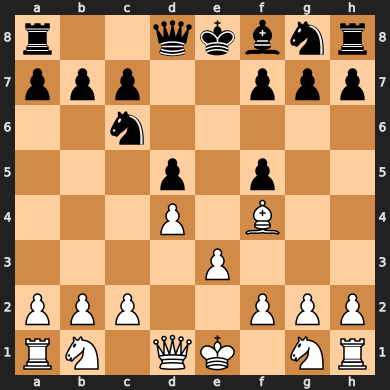

In [607]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
chess.Board(random_fen)

In [608]:
print(random_fen)

r2qkbnr/ppp2ppp/2n5/3p1p2/3P1B2/4P3/PPP2PPP/RN1QK1NR w KQkq - 0 6


In [609]:
filtered.drop("fen", axis=1).set_index('next_move').T

next_move,g1f3
games_count,120
global_avg_elo,1420.608333
global_winrate,0.508333
engine_move,g1e2
delta,-0.17789
...,...
historical_best_2500,None
is_best_2500,<NA>
is_engine_best_2500,<NA>
is_top3_2500,<NA>


In [610]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 91 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    126 non-null    object 
 1   next_move              126 non-null    object 
 2   games_count            126 non-null    int64  
 3   global_avg_elo         126 non-null    float64
 4   global_winrate         126 non-null    float64
 5   engine_move            126 non-null    object 
 6   delta                  126 non-null    float64
 7   fragility_score        126 non-null    float64
 8   variance               126 non-null    float64
 9   score                  126 non-null    float64
 10  group_count_500        5 non-null      float64
 11  winrate_500            5 non-null      float64
 12  score_500              126 non-null    float64
 13  recommended_move_500   126 non-null    object 
 14  historical_best_500    7 non-null      object 
 15  is_bes

In [611]:
df["f_cross_d"] = df["fragility_score"] * df["delta"]
df["f_cross_v"] = df["fragility_score"] * df["variance"]
df["d_cross_v"] = df["delta"] * df["variance"]

df_reg = df[pd.notna(df["is_best_1500"])]
selected_features = ["fragility_score", "delta", "variance", "f_cross_d", "f_cross_v", "d_cross_v"]
X = df_reg[selected_features]
y = df_reg["is_best_1500"].fillna(False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [612]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {acc_log:.3f}")

Logistic Regression Accuracy: 0.724


In [613]:
print("Logistic Regression Coefficients:")
for feature, coef in zip(selected_features, log_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

Logistic Regression Coefficients:
fragility_score: -0.836
delta: 0.007
variance: 0.206
f_cross_d: -0.216
f_cross_v: -0.090
d_cross_v: 0.088


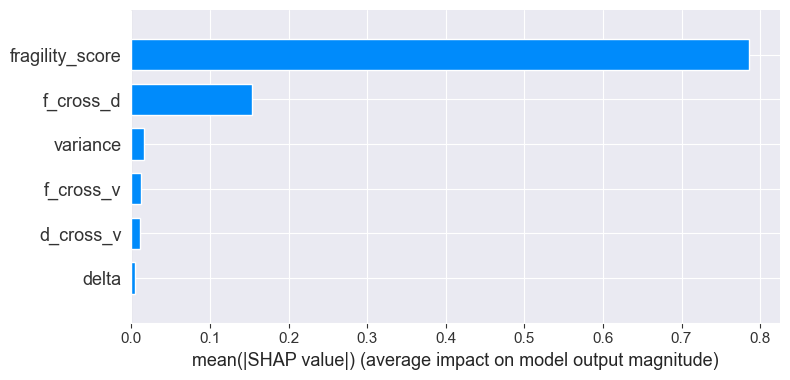

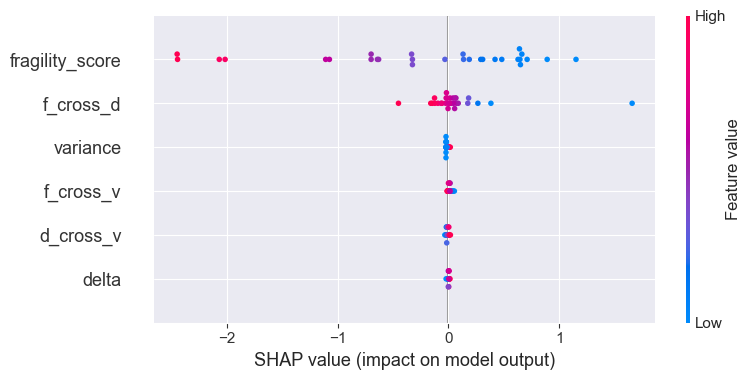

In [614]:
explainer_log = shap.Explainer(log_model, X_train)
shap_values_log = explainer_log(X_test)
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, show=True)

In [615]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.3f}")

XGBoost Accuracy: 0.690


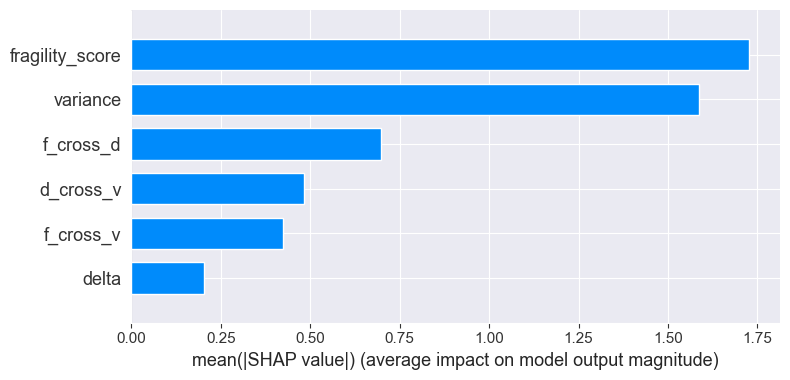

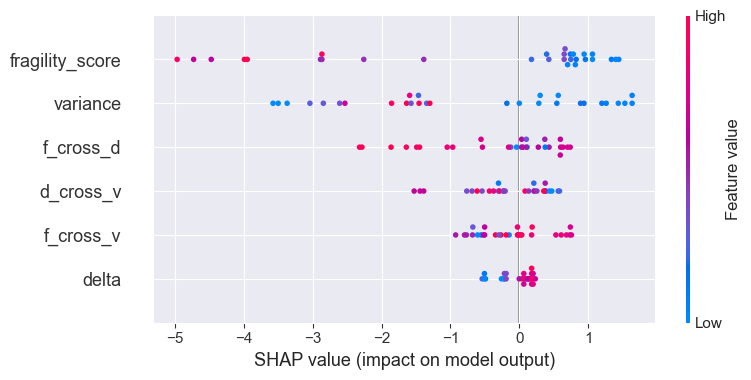

In [616]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, show=True)